In [81]:
import pandas as pd
import numpy as np
import gym_anytrading
from finta import TA
from sklearn.model_selection import train_test_split
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from environment import CustomTradingEnv 
from tqdm import tqdm
import seaborn as sns

In [82]:
df = gym_anytrading.datasets.STOCKS_GOOGL.copy()
df.shape

(2335, 6)

In [83]:
from finta import TA
df['TEMA'] = TA.TEMA(df, 30) # Triple Exponential Moving Average --> in ce directie se indreapta pretul pe parcursul a 12 zile cu accent mare pe ultimele zile
df['ER'] = TA.ER(df) # Kaufman Efficiency Indicator --> confirmare a trendului (-1,1) : -1 downtrend, 1 uptrend, aprox 0 random (trend confirmation)
df['RSI'] = TA.RSI(df) # Relative Strength Index --> intre 0 si 100, 30-70 intervalul de interes, 30-0 oversold, 70-100 overbought (trend confirmation)
df['OBV'] = TA.OBV(df) # On Balance Volume --> confirmare a trendului (trend confirmation) --> se bazeaza pe volumul tranzactiilor
df['STOCH'] = TA.STOCH(df) # Stochastic Oscillator --> confirmare a trendului (trend confirmation) --> intre 0 si 100, 20-80 intervalul de interes, 20-0 oversold, 80-100 overbought
df.fillna(0, inplace=True)
df.head(20)

,Open,High,Low,Close,Adj Close,Volume,TEMA,ER,RSI,OBV,STOCH
Date,,,,,,,,,,,
2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700,196.946945,0.000000,0.000000,0.0,0.000000
2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700,201.768658,0.000000,100.000000,6202700.0,0.000000
2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500,203.105999,0.000000,100.000000,12265200.0,0.000000
2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200,204.966986,0.000000,100.000000,17597400.0,0.000000
2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100,207.561945,0.000000,100.000000,22888500.0,0.000000
2009-06-01,209.574570,215.015015,209.474472,213.493500,213.493500,6638100,211.077229,0.000000,100.000000,29526600.0,0.000000
2009-06-02,213.338333,215.195190,211.911911,214.414413,214.414413,5241900,213.421299,0.000000,100.000000,34768500.0,0.000000
2009-06-03,213.213211,216.446442,212.212219,216.041046,216.041046,7058500,215.420351,0.000000,100.000000,41827000.0,0.000000
2009-06-04,217.867874,220.840836,217.467468,220.360367,220.360367,7268900,218.225981,0.000000,100.000000,49095900.0,0.000000


In [84]:
from sklearn.model_selection import train_test_split


df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)


print("Training set shape:", df_train.shape)
print("Test set shape:", df_test.shape)

Training set shape: (1868, 11)
Test set shape: (467, 11)


In [85]:
env = CustomTradingEnv(df=df_train, window_size=30, frame_bound=(30, int(len(df_train) * 0.8)))
vectorized_env = DummyVecEnv([lambda: env])

In [86]:
model = A2C('MlpPolicy', vectorized_env, verbose=0, seed=42)

model.learn(total_timesteps=int(2e4), log_interval=1000) 
model.save("trained_a2c_model")

100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


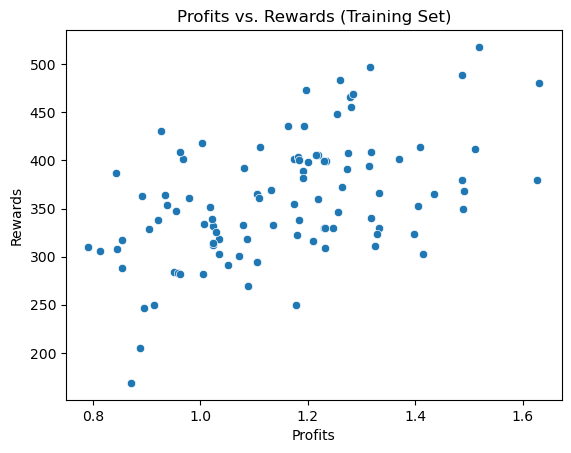

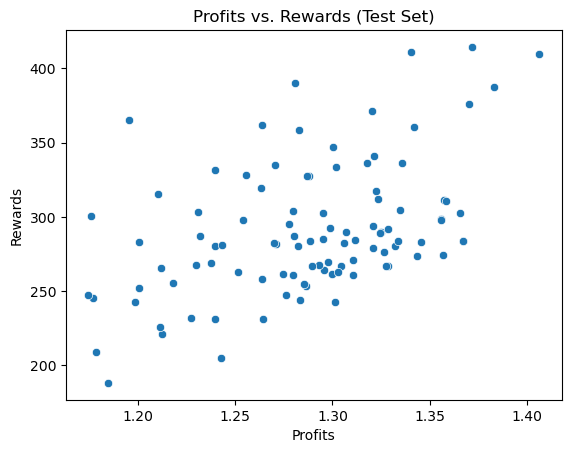

Mean Reward on Training Set: 359.14777174999995
Mean Profit on Training Set: 1.1552724260596652
Profit-to-Reward Ratio on Training Set: 0.003216704980321698

Mean Reward on Test Set: 291.1076997000001
Mean Profit on Test Set: 1.2871877487945347
Profit-to-Reward Ratio on Test Set: 0.00442168912097152


In [87]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_agent(df, model, episodes):
    env = CustomTradingEnv(df=df, frame_bound=(30, int(len(df) * 0.8)), window_size=30)
    mean_reward, mean_profit = 0, 0
    profits = []
    rewards = []
    
    for episode in tqdm(range(episodes)):
        state = env.reset()[0]
        while True:
            action, _ = model.predict(state)
            state, reward, _, done, info = env.step(action)
            if done:
                break
        mean_profit += info['total_profit']
        mean_reward += info['total_reward']
        profits.append(info['total_profit'])
        rewards.append(info['total_reward'])
    
    mean_reward /= episodes
    mean_profit /= episodes
    
    # Calculate the profit-to-reward ratio
    fr = mean_profit / mean_reward
    
    return mean_reward, mean_profit, fr, profits, rewards


mean_reward_train, mean_profit_train, fr_train, profits_train, rewards_train = evaluate_agent(df_train, model, episodes=100)


mean_reward_test, mean_profit_test, fr_test, profits_test, rewards_test = evaluate_agent(df_test, model, episodes=100)


profits_train = np.array(profits_train)
rewards_train = np.array(rewards_train)

sns.scatterplot(x=profits_train, y=rewards_train)
plt.title('Profits vs. Rewards (Training Set)')
plt.xlabel('Profits')
plt.ylabel('Rewards')
plt.show()


profits_test = np.array(profits_test)
rewards_test = np.array(rewards_test)

sns.scatterplot(x=profits_test, y=rewards_test)
plt.title('Profits vs. Rewards (Test Set)')
plt.xlabel('Profits')
plt.ylabel('Rewards')
plt.show()

print(f"Mean Reward on Training Set: {mean_reward_train}")
print(f"Mean Profit on Training Set: {mean_profit_train}")
print(f"Profit-to-Reward Ratio on Training Set: {fr_train}")

print(f"\nMean Reward on Test Set: {mean_reward_test}")
print(f"Mean Profit on Test Set: {mean_profit_test}")
print(f"Profit-to-Reward Ratio on Test Set: {fr_test}")
